In [1]:
import numpy as np
import cv2
import os
import glob
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from statannotations.Annotator import Annotator
import shutil
from tqdm.auto import tqdm

In [2]:
unique_ids = []
for path in os.listdir('output/'):
  unique_ids += [path[3:].split('-')[0]]
unique_ids = np.unique(unique_ids)
print(len(unique_ids))

23


In [3]:
# x = cv2.imread('input/img0001-slice100.png', 0)
# y = cv2.imread('SAM-vit_h-enhance-masks/img0001-slice100.png', 0)
# x = x/x.max()
# y = y/y.max()
# x = np.fliplr(np.flipud(np.rot90(x)))
# y = np.fliplr(np.flipud(np.rot90(y)))
# plt.figure()
# plt.imshow(x, cmap='gray')
# plt.imshow(y, alpha=0.5, cmap='magma')

In [4]:
# model = 'SAM-vit_h'

# os.makedirs(f'../BTCV_Crowdsourced/{model}-labels', exist_ok=True)

# def reorient(img):
#   return np.fliplr(np.flipud(np.rot90(img)))

# for id in tqdm(unique_ids):
#   label_o = nib.load(f'../data/btcv/Training/labels/label{id}.nii.gz')
#   shape = label_o.header['dim'][1:4]
#   label_s = np.zeros(shape)
#   for i in range(shape[-1]):
#     if os.path.exists(f'{model}-masks/img{id}-slice{i:03}.png'):
#       label_s[:,:,i] = reorient(
#         cv2.imread(f'{model}-masks/img{id}-slice{i:03}.png', 0)
#       )
#   img = nib.Nifti1Image(label_s, label_o.affine, label_o.header)
#   nib.save(img, f'../BTCV_Crowdsourced/{model}-labels/label{id}.nii.gz')

In [5]:
def dice(
  y_pred,
  y_true
):
  # if y_pred.dtype != bool:
  #   y_pred = y_pred.astype(bool)
  # if y_true.dtype != bool:
  #   y_true = y_true.astype(bool)
  # if y_pred.ndim > 1:
  #   y_pred = y_pred.ravel()
  # if y_true.ndim > 1:
  #   y_true = y_true.ravel()
  return np.sum(y_pred & y_true)*2.0 / (np.sum(y_pred) + np.sum(y_true))

In [9]:
#### TODO: GET FROM ADWAY
# train_ids = [1, 2, 7, 10, 21, 23, 24, 27, 28, 29, 30, 32, 33, 34, 40]
train_ids = [1, 2, 7, 21, 27, 28, 29, 30, 33, 34, 40]
test_ids = [3, 4, 5, 6, 8, 9, 22, 25, 26, 31, 35, 36, 37, 38, 39]

In [16]:
for id in train_ids:
  slices = { 0: 0, 1: 0, 2: 0, 5: 0, 7: 0}
  for path in glob.glob(f'output/img{id:04}-slice*.txt'):
    with open(path, 'r') as f:
      for line in f.readlines():
        for target in slices.keys():
          if target == int(line.split()[0]):
            slices[target] += 1
  print(id, slices)

1 {0: 36, 1: 40, 2: 36, 5: 74, 7: 76}
2 {0: 21, 1: 28, 2: 33, 5: 55, 7: 76}
7 {0: 40, 1: 34, 2: 38, 5: 67, 7: 73}
10 {0: 0, 1: 0, 2: 0, 5: 0, 7: 3}
21 {0: 21, 1: 14, 2: 9, 5: 36, 7: 45}
23 {0: 0, 1: 10, 2: 12, 5: 12, 7: 21}
24 {0: 0, 1: 0, 2: 0, 5: 0, 7: 1}
27 {0: 17, 1: 22, 2: 20, 5: 40, 7: 45}
28 {0: 16, 1: 18, 2: 18, 5: 40, 7: 45}
29 {0: 1, 1: 20, 2: 13, 5: 5, 7: 35}
30 {0: 34, 1: 15, 2: 22, 5: 35, 7: 35}
32 {0: 3, 1: 0, 2: 0, 5: 3, 7: 3}
33 {0: 20, 1: 21, 2: 18, 5: 31, 7: 51}
34 {0: 22, 1: 20, 2: 22, 5: 26, 7: 43}
40 {0: 22, 1: 15, 2: 13, 5: 31, 7: 52}


In [11]:
labels = [1, 2, 3, 6, 8]
  
res = []
for model in ['SAM-vit_h', 'MedSAM-vit_b']:
  for id in tqdm(train_ids):
    y_true = nib.load(f'../data/btcv/Training/labels/label{id:04}.nii.gz').get_fdata().ravel().astype(int)
    y_pred = nib.load(f'../DataCuration_Grant/BTCV_Crowdsourced/{model}-labels/label{id:04}.nii.gz').get_fdata().ravel().astype(int)
    # Filter labels
    y_true[~np.isin(y_true, labels)] = 0
    y_true[y_true == 6] = 4
    y_true[y_true == 8] = 5
    # Calculate dice
    labels_found = np.unique(y_pred)[1:]
    scores = [np.nan]*len(labels)
    for label in labels_found:
      scores[label-1] = dice(y_pred == label, y_true == label)
    res += [[model, f'img{id:04}.nii.gz'] + scores]
pd.DataFrame(np.array(res), columns=['model', 'path', 'spleen_dice', 'rkidney_dice', 'lkidney_dice', 'liver_dice', 'aorta_dice']).to_csv(f'../DataCuration_Grant/BTCV_Crowdsourced/volume_dice.csv', index=False)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

In [12]:
labels = [1, 2, 3, 6, 8]
  
res = []
for model in ['SAM-vit_h', 'MedSAM-vit_b']:
  for id in tqdm(train_ids):
    y_true = nib.load(f'../data/btcv/Training/labels/label{id:04}.nii.gz').get_fdata().astype(int)
    y_pred = nib.load(f'../DataCuration_Grant/BTCV_Crowdsourced/{model}-labels/label{id:04}.nii.gz').get_fdata().astype(int)
    # Filter labels
    y_true[~np.isin(y_true, labels)] = 0
    y_true[y_true == 6] = 4
    y_true[y_true == 8] = 5
    for slice in range(y_true.shape[-1]):
      # Calculate dice
      labels_found = np.unique(y_pred[:,:,slice])[1:]
      scores = [np.nan]*len(labels)
      for label in labels_found:
        scores[label-1] = dice(y_pred[:,:,slice] == label, y_true[:,:,slice] == label)
      res += [[model, f'img{id:04}.nii.gz', slice] + scores]
pd.DataFrame(np.array(res), columns=['model', 'path', 'slice_idx', 'spleen_dice', 'rkidney_dice', 'lkidney_dice', 'liver_dice', 'aorta_dice']).to_csv(f'../DataCuration_Grant/BTCV_Crowdsourced/slice_dice.csv', index=False)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

In [65]:
# task = 'Task03_Liver'
task = 'Task09_Spleen'

res = []
for model in ['SAM-vit_h', 'MedSAM-vit_b']:
  for path in tqdm(np.sort(glob.glob(f'../DataCuration_Grant/MSD_Simulated/{task}/{model}/*.nii.gz'))):
    id = os.path.split(path)[-1]
    y_true = nib.load(f'../data/MSD/{task}/labelsTr/{id}').get_fdata().ravel().astype(int)
    y_pred = nib.load(f'../DataCuration_Grant/MSD_Simulated/{task}/{model}/{id}').get_fdata().ravel().astype(int)
    # Filter labels
    label = 1
    y_true[y_true != label] = 0
    # Calculate dice
    score = dice(y_pred == label, y_true == label)
    res += [[model, id, score]]
pd.DataFrame(np.array(res), columns=['model', 'path', 'dice']).to_csv(f'../DataCuration_Grant/MSD_Simulated/{task}/volume_dice.csv', index=False)

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

In [85]:
task = 'Task03_Liver'
# task = 'Task09_Spleen'
  
res = []
for model in ['SAM-vit_h', 'MedSAM-vit_b']:
  for path in tqdm(np.sort(glob.glob(f'../DataCuration_Grant/MSD_Simulated/{task}/{model}/*.nii.gz'))):
    id = os.path.split(path)[-1]
    y_true = nib.load(f'../data/MSD/{task}/labelsTr/{id}').get_fdata().astype(int)
    y_pred = nib.load(f'../DataCuration_Grant/MSD_Simulated/{task}/{model}/{id}').get_fdata().astype(int)
    # Filter labels
    label = 1
    y_true[y_true != label] = 0
    for slice in range(y_true.shape[-1]):
      # Calculate dice
      labels_found = np.unique(y_pred[:,:,slice])[1:]
      score = np.nan
      for label in labels_found:
        score = dice(y_pred[:,:,slice] == label, y_true[:,:,slice] == label)
      res += [[model, id, slice, score]]
pd.DataFrame(np.array(res), columns=['model', 'path', 'slice_idx', 'dice']).to_csv(f'../DataCuration_Grant/MSD_Simulated/{task}/slice_dice.csv', index=False)

  0%|          | 0/131 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

In [19]:
model = 'MedSAM-vit_b'
labels = ['spleen_dice', 'rkidney_dice', 'lkidney_dice', 'liver_dice', 'aorta_dice']

df = pd.read_csv(f'../DataCuration_Grant/BTCV_Crowdsourced/volume_dice.csv')
#### TODO: Uncomment everything below
# df = pd.read_csv(f'../DataCuration_Grant/BTCV_Crowdsourced/slice_dice.csv')
# df_a = df[df.model == 'SAM-vit_h']
# df_b = df[df.model == 'MedSAM-vit_b']
# df = pd.merge(df_a, df_b, on=['path', 'slice_idx'])
# df = df.dropna()
# df_a = df[['model_x', 'path', 'slice_idx', 'spleen_dice_x', 'rkidney_dice_x', 'lkidney_dice_x', 'liver_dice_x', 'aorta_dice_x']]
# df_a.columns = ['model', 'path', 'slice_idx', 'spleen_dice', 'rkidney_dice', 'lkidney_dice', 'liver_dice', 'aorta_dice']
# df_b = df[['model_y', 'path', 'slice_idx', 'spleen_dice_y', 'rkidney_dice_y', 'lkidney_dice_y', 'liver_dice_y', 'aorta_dice_y']]
# df_b.columns = ['model', 'path', 'slice_idx', 'spleen_dice', 'rkidney_dice', 'lkidney_dice', 'liver_dice', 'aorta_dice']
# df = pd.concat((df_a, df_b))

df = df[df.model == model]
x = np.mean(df[labels].values, axis=1)
print('mean', np.nanmean(x), 1.96*np.nanstd(x)/np.sqrt(len(x))) 

for label in labels:
  x = df[label].values
  print(label, np.nanmean(x), 1.96*np.nanstd(x)/np.sqrt(len(x)))

mean 0.7391245701316446 0.08622625009396653
spleen_dice 0.7826702383096148 0.1443342244393353
rkidney_dice 0.7717818558681407 0.09483128201116864
lkidney_dice 0.7379535961310044 0.1030767417761945
liver_dice 0.7518359244384863 0.13530406968557343
aorta_dice 0.6513812359109766 0.09126139154111192


In [20]:
model_x = 'SAM-vit_h'
model_y = 'MedSAM-vit_b'
labels = ['spleen_dice', 'rkidney_dice', 'lkidney_dice', 'liver_dice', 'aorta_dice']

df = pd.read_csv(f'../DataCuration_Grant/BTCV_Crowdsourced/volume_dice.csv')
#### TODO: Uncomment everything below
# df = pd.read_csv(f'../DataCuration_Grant/BTCV_Crowdsourced/slice_dice.csv')
# df_a = df[df.model == 'SAM-vit_h']
# df_b = df[df.model == 'MedSAM-vit_b']
# df = pd.merge(df_a, df_b, on=['path', 'slice_idx'])
# df = df.dropna()
# df_a = df[['model_x', 'path', 'slice_idx', 'spleen_dice_x', 'rkidney_dice_x', 'lkidney_dice_x', 'liver_dice_x', 'aorta_dice_x']]
# df_a.columns = ['model', 'path', 'slice_idx', 'spleen_dice', 'rkidney_dice', 'lkidney_dice', 'liver_dice', 'aorta_dice']
# df_b = df[['model_y', 'path', 'slice_idx', 'spleen_dice_y', 'rkidney_dice_y', 'lkidney_dice_y', 'liver_dice_y', 'aorta_dice_y']]
# df_b.columns = ['model', 'path', 'slice_idx', 'spleen_dice', 'rkidney_dice', 'lkidney_dice', 'liver_dice', 'aorta_dice']
# df = pd.concat((df_a, df_b))

df_x = df[df.model == model_x]
df_y = df[df.model == model_y]

x = np.nanmean(df_x[labels].values, axis=1)
y = np.nanmean(df_y[labels].values, axis=1)
print('mean', stats.wilcoxon(x, y, nan_policy='omit').pvalue)

for label in labels:
  x = df_x[label].values
  y = df_y[label].values
  print(label, stats.wilcoxon(x, y, nan_policy='omit').pvalue)

mean 0.7001953125
spleen_dice 0.8984375
rkidney_dice 0.9658203125
lkidney_dice 0.7646484375
liver_dice 0.123046875
aorta_dice 0.0830078125


In [143]:
# model = 'SAM-vit_h'
model = 'MedSAM-vit_b'
# task = 'Task03_Liver'
task = 'Task09_Spleen'

# df = pd.read_csv(f'../DataCuration_Grant/MSD_Simulated/{task}/volume_dice.csv')
df = pd.read_csv(f'../DataCuration_Grant/MSD_Simulated/{task}/slice_dice.csv')
df_a = df[df.model == 'SAM-vit_h']
df_b = df[df.model == 'MedSAM-vit_b']
df = pd.merge(df_a, df_b, on=['path', 'slice_idx'])
df = df.dropna()
df_a = df[['model_x', 'path', 'slice_idx', 'dice_x']]
df_a.columns = ['model', 'path', 'slice_idx', 'dice']
df_b = df[['model_y', 'path', 'slice_idx', 'dice_y']]
df_b.columns = ['model', 'path', 'slice_idx', 'dice']
df = pd.concat((df_a, df_b))

df = df[df.model == model]
x = df['dice'].values
print(np.nanmean(x), 1.96*np.nanstd(x)/np.sqrt(len(x))) 

0.832957408546414 0.009465803687203641


In [145]:
model_x = 'SAM-vit_h'
model_y = 'MedSAM-vit_b'
# task = 'Task03_Liver'
task = 'Task09_Spleen'

# df = pd.read_csv(f'../DataCuration_Grant/MSD_Simulated/{task}/volume_dice.csv')
df = pd.read_csv(f'../DataCuration_Grant/MSD_Simulated/{task}/slice_dice.csv')
df_a = df[df.model == 'SAM-vit_h']
df_b = df[df.model == 'MedSAM-vit_b']
df = pd.merge(df_a, df_b, on=['path', 'slice_idx'])
df = df.dropna()
df_a = df[['model_x', 'path', 'slice_idx', 'dice_x']]
df_a.columns = ['model', 'path', 'slice_idx', 'dice']
df_b = df[['model_y', 'path', 'slice_idx', 'dice_y']]
df_b.columns = ['model', 'path', 'slice_idx', 'dice']
df = pd.concat((df_a, df_b))

df_x = df[df.model == model_x]
df_y = df[df.model == model_y]

x = df_x['dice'].values
y = df_y['dice'].values
print(stats.wilcoxon(x, y, nan_policy='omit').pvalue)

4.4174682412185174e-11


In [73]:
# task = 'Task03_Liver'
task = 'Task09_Spleen'
label = 1

for t in ['SAM', 'GT']:
  res = []
  for path in tqdm(glob.glob(f'../DataCuration_Grant/MSD_Simulated/{task}/{t}-nnunet-pred/*.nii.gz')):
    id = os.path.split(path)[-1]
    y_true = nib.load(f'../data/btcv/Training/labels/{id}').get_fdata().ravel().astype(int)
    y_pred = nib.load(path).get_fdata().ravel().astype(int)
    y_true[y_true != label] = 0
    y_true[y_true == label] = 1
  #   plt.figure()
  #   plt.imshow(y_true[:,:,85])
  #   plt.figure()
  #   plt.imshow(y_pred[:,:,85])
  #   break
  # break
    # Calculate dice
    score = dice(y_pred == 1, y_true == 1)
    res += [[id, score]]
  pd.DataFrame(np.array(res), columns=['path', 'dice']).to_csv(f'../DataCuration_Grant/MSD_Simulated/{task}/{t}-nnunet-pred.csv', index=False)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

In [65]:
# task = 'Task03_Liver'
task = 'Task09_Spleen'

x = pd.read_csv(f'../DataCuration_Grant/MSD_Simulated/{task}/GT-nnunet-pred.csv')['dice'].values
print(x.mean(), 1.96*x.std()/np.sqrt(len(x)))
y = pd.read_csv(f'../DataCuration_Grant/MSD_Simulated/{task}/SAM-nnunet-pred.csv')['dice'].values
print(y.mean(), 1.96*y.std()/np.sqrt(len(x)))

print(stats.wilcoxon(x, y).pvalue)

0.8651476594377422 0.06251306284539772
0.8100252746409622 0.07124683783877035
0.004338232800364494


In [15]:
labels = [1, 2, 3, 6, 8]
n = 11

for t in ['SAM', 'GT']:
  res = []
  for path in tqdm(glob.glob(f'../DataCuration_Grant/BTCV_Crowdsourced/{t}-nnunet-{n}-pred/*.nii.gz')):
    id = os.path.split(path)[-1]
    y_true = nib.load(f'../data/btcv/Training/labels/{id}').get_fdata().ravel().astype(int)
    y_pred = nib.load(path).get_fdata().ravel().astype(int)
    # Filter labels
    y_true[~np.isin(y_true, labels)] = 0
    y_true[y_true == 6] = 4
    y_true[y_true == 8] = 5
    # Calculate dice
    labels_found = np.unique(y_pred)[1:]
    scores = [np.nan]*len(labels)
    for label in labels_found:
      scores[label-1] = dice(y_pred == label, y_true == label)
    res += [[id] + scores]
  pd.DataFrame(np.array(res), columns=['path', 'spleen_dice', 'rkidney_dice', 'lkidney_dice', 'liver_dice', 'aorta_dice']).to_csv(f'../DataCuration_Grant/BTCV_Crowdsourced/{t}-nnunet-{n}-pred.csv', index=False)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [14]:
labels = ['spleen_dice', 'rkidney_dice', 'lkidney_dice', 'liver_dice', 'aorta_dice']
# n = 11

# df_x = pd.read_csv(f'../DataCuration_Grant/BTCV_Crowdsourced/GT-nnunet-{n}-pred.csv')[labels]
# df_y = pd.read_csv(f'../DataCuration_Grant/BTCV_Crowdsourced/SAM-nnunet-{n}-pred.csv')[labels]


df_x = pd.read_csv(f'../DataCuration_Grant/BTCV_Crowdsourced/GT-nnunet-11-pred.csv')[labels]
df_y = pd.read_csv(f'../DataCuration_Grant/BTCV_Crowdsourced/GT-nnunet-15-pred.csv')[labels]

x = df_x.values.mean(axis=1)
y = df_y.values.mean(axis=1)

print('mean GT', x.mean(), 1.96*x.std()/np.sqrt(len(x)))
print('mean SAM', y.mean(), 1.96*y.std()/np.sqrt(len(y)))
print(stats.wilcoxon(x, y).pvalue)

for label in labels:
  x = df_x[label].values
  y = df_y[label].values

  print(f'{label} GT', x.mean(), 1.96*x.std()/np.sqrt(len(x)))
  print(f'{label} SAM', y.mean(), 1.96*y.std()/np.sqrt(len(y)))
  print(stats.wilcoxon(x, y).pvalue)

mean GT 0.8958079059002066 0.05392208196880035
mean SAM 0.9072085812435606 0.05238048786408078
0.063720703125
spleen_dice GT 0.8770870822470649 0.1098467974881935
spleen_dice SAM 0.8743415664745545 0.11750229002772027
0.5614013671875
rkidney_dice GT 0.866793390272721 0.11108279698560837
rkidney_dice SAM 0.8967394892606667 0.09837850104045993
0.041259765625
lkidney_dice GT 0.8726071835441715 0.11720552759265794
lkidney_dice SAM 0.8957192568591786 0.10732477470830473
0.063720703125
liver_dice GT 0.9390419119930534 0.04970825905407003
liver_dice SAM 0.940449678366236 0.050549879214786125
0.22930908203125
aorta_dice GT 0.923509961444021 0.010769663090269627
aorta_dice SAM 0.9287929152571669 0.008887913405591306
0.00836181640625


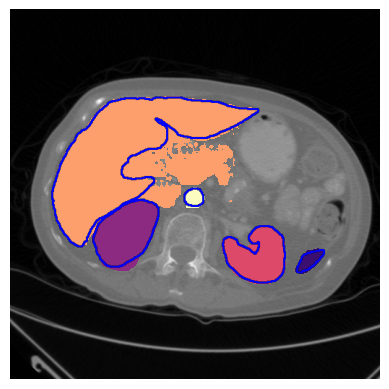

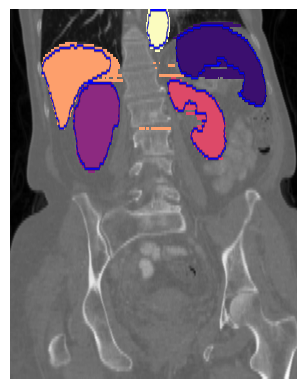

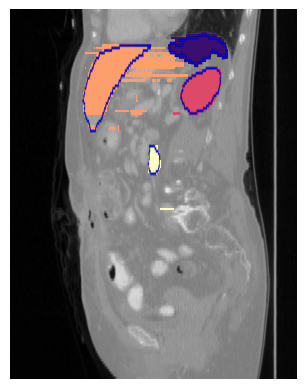

In [75]:
img = nib.load('../data/btcv/Training/img/img0001.nii.gz')
gt = nib.load('../data/btcv/Training/labels/label0001.nii.gz')
sam = nib.load('../DataCuration_Grant/BTCV_Crowdsourced/SAM-vit_h-labels/label0001.nii.gz')

labels = [1, 2, 3, 6, 8]

ps = img.header['pixdim'][1:4]
ax_aspect = ps[1]/ps[0]
sag_aspect = ps[1]/ps[2]
cor_aspect = ps[2]/ps[0]

img = img.get_fdata()
img = ((img - img.min())/(img.max() - img.min()) * 255).astype(np.uint8)
gt = gt.get_fdata()
sam = sam.get_fdata()

# Filter labels
gt[~np.isin(gt, labels)] = 0
gt[gt == 6] = 4
gt[gt == 8] = 5

ax_img = np.rot90(img[:,:,106])
# ax_img = ((ax_img - ax_img.min())/(ax_img.max() - ax_img.min()) * 255).astype(np.uint8)
ax_gt = np.rot90(gt[:,:,106]).astype(np.uint8)
ax_sam = np.rot90(sam[:,:,106]).astype(np.uint8)

cm = plt.get_cmap('magma', lut=6)
ax_sam = (cm(ax_sam) * 255).astype(np.uint8)
ax_sam[(ax_sam == [0,0,3,255]).all(axis=2)] = 0

ax_gt_border = np.zeros(ax_sam.shape, dtype=np.uint8)
for label in [1,2,3,4,5]:
  contours, _ = cv2.findContours((ax_gt == label).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  for i, c in enumerate(contours):
      cv2.drawContours(ax_gt_border, [c], -1, (0,0,255,255), 2, lineType=cv2.LINE_4)

plt.figure()
plt.imshow(ax_img, cmap='gray')
plt.imshow(ax_sam, interpolation='nearest')
plt.imshow(ax_gt_border)
plt.gca().set_aspect(1/ax_aspect)
plt.axis('off')
plt.savefig('../DataCuration_Grant/BTCV_Crowdsourced/ax_example.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

ax_img = np.rot90(img[:,195,:])
# ax_img = ((ax_img - ax_img.min())/(ax_img.max() - ax_img.min()) * 255).astype(np.uint8)
ax_gt = np.rot90(gt[:,195,:]).astype(np.uint8)
ax_sam = np.rot90(sam[:,195,:]).astype(np.uint8)

cm = plt.get_cmap('magma', lut=6)
ax_sam = (cm(ax_sam) * 255).astype(np.uint8)
ax_sam[(ax_sam == [0,0,3,255]).all(axis=2)] = 0

ax_gt_border = np.zeros(ax_sam.shape, dtype=np.uint8)
for label in [1,2,3,4,5]:
  contours, _ = cv2.findContours((ax_gt == label).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  for i, c in enumerate(contours):
      cv2.drawContours(ax_gt_border, [c], -1, (0,0,255,255), 1, lineType=cv2.LINE_4)

plt.figure()
plt.imshow(ax_img, cmap='gray')
plt.imshow(ax_sam, interpolation='nearest')
plt.imshow(ax_gt_border)
plt.gca().set_aspect(1/sag_aspect)
plt.axis('off')
plt.savefig('../DataCuration_Grant/BTCV_Crowdsourced/sag_example.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

ax_img = np.fliplr(np.rot90(img[298,:,:]))
# ax_img = ((ax_img - ax_img.min())/(ax_img.max() - ax_img.min()) * 255).astype(np.uint8)
ax_gt = np.fliplr(np.rot90(gt[298,:,:])).astype(np.uint8)
ax_sam = np.fliplr(np.rot90(sam[298,:,:])).astype(np.uint8)

cm = plt.get_cmap('magma', lut=6)
ax_sam = (cm(ax_sam) * 255).astype(np.uint8)
ax_sam[(ax_sam == [0,0,3,255]).all(axis=2)] = 0

ax_gt_border = np.zeros(ax_sam.shape, dtype=np.uint8)
for label in [1,2,3,4,5]:
  contours, _ = cv2.findContours((ax_gt == label).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  for i, c in enumerate(contours):
      cv2.drawContours(ax_gt_border, [c], -1, (0,0,255,255), 1, lineType=cv2.LINE_4)

plt.figure()
plt.imshow(ax_img, cmap='gray')
plt.imshow(ax_sam, interpolation='nearest')
plt.imshow(ax_gt_border)
plt.gca().set_aspect(cor_aspect)
plt.axis('off')
plt.savefig('../DataCuration_Grant/BTCV_Crowdsourced/cor_example.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

GT vs. SAM: Wilcoxon test (paired samples), P_val:5.718e-07 Stat=1.900e+01


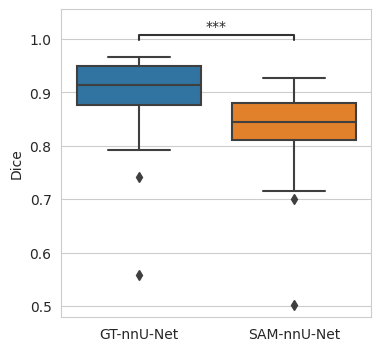

In [20]:
sns.set_style('whitegrid')

task = 'Task03_Liver'
# task = 'Task09_Spleen'

# df = pd.read_csv(f'../DataCuration_Grant/MSD_Simulated/{task}/volume_dice.csv')
# pairs = [('SAM-vit_h', 'MedSAM-vit_b')]

# plt.figure(figsize = (4,4))
# ax = sns.boxplot(df, x='model', y='dice')
# annotator = Annotator(ax, pairs, data=df, x='model', y='dice')
# annotator.configure(test='Wilcoxon')
# annotator._pvalue_format.pvalue_thresholds =  [[0.001, '***'], [0.01, '**'], [0.05, '*'], [1, 'ns']]
# annotator.apply_and_annotate()
# plt.xlabel(None)
# plt.ylabel('Dice')
# plt.xticks([0, 1], ['SAM', 'MedSAM'])
# # plt.savefig(f'../DataCuration_Grant/MSD_Simulated/{task}/fig_volume_dice.png', bbox_inches='tight', dpi=300)
# plt.show()

# df = pd.read_csv(f'../DataCuration_Grant/MSD_Simulated/{task}/slice_dice.csv')
# # df = df.groupby(['model', 'path'], sort=False).mean().reset_index()
# df_a = df[df.model == 'SAM-vit_h']
# df_b = df[df.model == 'MedSAM-vit_b']
# df = pd.merge(df_a, df_b, on=['path', 'slice_idx'])
# df = df.dropna()
# df_a = df[['model_x', 'path', 'slice_idx', 'dice_x']]
# df_a.columns = ['model', 'path', 'slice_idx', 'dice']
# df_b = df[['model_y', 'path', 'slice_idx', 'dice_y']]
# df_b.columns = ['model', 'path', 'slice_idx', 'dice']
# df = pd.concat((df_a, df_b))
# pairs = [('SAM-vit_h', 'MedSAM-vit_b')]

# plt.figure(figsize = (4,4))
# ax = sns.boxplot(df, x='model', y='dice')
# annotator = Annotator(ax, pairs, data=df, x='model', y='dice')
# annotator.configure(test='Wilcoxon', )
# annotator._pvalue_format.pvalue_thresholds =  [[0.001, '***'], [0.01, '**'], [0.05, '*'], [1, 'ns']]
# annotator.apply_and_annotate()
# plt.xlabel(None)
# plt.ylabel('Dice')
# plt.xticks([0, 1], ['SAM', 'MedSAM'])
# plt.savefig(f'../DataCuration_Grant/MSD_Simulated/{task}/fig_slice_dice.png', bbox_inches='tight', dpi=300)
# plt.show()

df_gt = pd.read_csv(f'../DataCuration_Grant/MSD_Simulated/{task}/GT-nnunet-pred.csv')
df_gt['model'] = 'GT' 

df_sam = pd.read_csv(f'../DataCuration_Grant/MSD_Simulated/{task}/SAM-nnunet-pred.csv')
df_sam['model'] = 'SAM' 

df = pd.concat((df_gt, df_sam))

pairs = [('GT', 'SAM')]

plt.figure(figsize = (4,4))
ax = sns.boxplot(data=df, x='model', y='dice')
annotator = Annotator(ax, pairs, data=df, x='model', y='dice')
annotator.configure(test='Wilcoxon')
annotator._pvalue_format.pvalue_thresholds =  [[0.001, '***'], [0.01, '**'], [0.05, '*'], [1, 'ns']]
annotator.apply_and_annotate()
plt.xlabel(None)
plt.ylabel('Dice')
plt.xticks([0, 1], ['GT-nnU-Net', 'SAM-nnU-Net'])
# plt.savefig(f'../DataCuration_Grant/MSD_Simulated/{task}/fig_nnunet_dice.png', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
sns.set_style('whitegrid')

labels = ['spleen_dice', 'rkidney_dice', 'lkidney_dice', 'liver_dice', 'aorta_dice']
titles = ['Spleen', 'Right Kidney', 'Left Kidney', 'Liver', 'Aorta']

df = pd.read_csv(f'../DataCuration_Grant/BTCV_Crowdsourced/volume_dice.csv')
pairs = [('SAM-vit_h', 'MedSAM-vit_b')]

for i, label in enumerate(labels):
  plt.figure(figsize = (4,4))
  ax = sns.boxplot(df, x='model', y=label)
  annotator = Annotator(ax, pairs, data=df, x='model', y=label)
  annotator.configure(test='Wilcoxon')
  annotator._pvalue_format.pvalue_thresholds =  [[0.001, '***'], [0.01, '**'], [0.05, '*'], [1, 'ns']]
  annotator.apply_and_annotate()
  plt.xlabel(None)
  plt.ylabel('Dice')
  plt.xticks([0, 1], ['SAM', 'MedSAM'])
  plt.title(titles[i])
  plt.ylim((-0.05, 1.1))
  # plt.savefig(f'../DataCuration_Grant/BTCV_Crowdsourced/fig_{label}_volume_dice.png', bbox_inches='tight', dpi=300)
  plt.show()

In [ ]:
sns.set_style('whitegrid')

labels = ['spleen_dice', 'rkidney_dice', 'lkidney_dice', 'liver_dice', 'aorta_dice']
titles = ['Spleen', 'Right Kidney', 'Left Kidney', 'Liver', 'Aorta']

df = pd.read_csv(f'../DataCuration_Grant/BTCV_Crowdsourced/slice_dice.csv')
df_a = df[df.model == 'SAM-vit_h']
df_b = df[df.model == 'MedSAM-vit_b']
df = pd.merge(df_a, df_b, on=['path', 'slice_idx'])
df = df.dropna()
df_a = df[['model_x', 'path', 'slice_idx', 'spleen_dice_x', 'rkidney_dice_x', 'lkidney_dice_x', 'liver_dice_x', 'aorta_dice_x']]
df_a.columns = ['model', 'path', 'slice_idx', 'spleen_dice', 'rkidney_dice', 'lkidney_dice', 'liver_dice', 'aorta_dice']
df_b = df[['model_y', 'path', 'slice_idx', 'spleen_dice_y', 'rkidney_dice_y', 'lkidney_dice_y', 'liver_dice_y', 'aorta_dice_y']]
df_b.columns = ['model', 'path', 'slice_idx', 'spleen_dice', 'rkidney_dice', 'lkidney_dice', 'liver_dice', 'aorta_dice']
df = pd.concat((df_a, df_b))

pairs = [('SAM-vit_h', 'MedSAM-vit_b')]

for i, label in enumerate(labels):
  plt.figure(figsize = (4,4))
  ax = sns.boxplot(df, x='model', y=label)
  annotator = Annotator(ax, pairs, data=df, x='model', y=label)
  annotator.configure(test='Wilcoxon')
  annotator._pvalue_format.pvalue_thresholds =  [[0.001, '***'], [0.01, '**'], [0.05, '*'], [1, 'ns']]
  annotator.apply_and_annotate()
  plt.xlabel(None)
  plt.ylabel('Dice')
  plt.xticks([0, 1], ['SAM', 'MedSAM'])
  plt.title(titles[i])
  plt.ylim((-0.05, 1.15))
  # plt.savefig(f'../DataCuration_Grant/BTCV_Crowdsourced/fig_{label}_slice_dice.png', bbox_inches='tight', dpi=300)
  plt.show()

In [ ]:
sns.set_style('whitegrid')

labels = ['spleen_dice', 'rkidney_dice', 'lkidney_dice', 'liver_dice', 'aorta_dice']
titles = ['Spleen', 'Right Kidney', 'Left Kidney', 'Liver', 'Aorta']

n = 11
 
df_gt = pd.read_csv(f'../DataCuration_Grant/BTCV_Crowdsourced/GT-nnunet-{n}-pred.csv')
df_gt['model'] = 'GT' 

df_sam = pd.read_csv(f'../DataCuration_Grant/BTCV_Crowdsourced/SAM-nnunet-{n}-pred.csv')
df_sam['model'] = 'SAM' 

df = pd.concat((df_gt, df_sam))

pairs = [('GT', 'SAM')]

for i, label in enumerate(labels):
  plt.figure(figsize = (4,4))
  ax = sns.boxplot(data=df, x='model', y=label)
  annotator = Annotator(ax, pairs, data=df, x='model', y=label)
  annotator.configure(test='Wilcoxon')
  annotator._pvalue_format.pvalue_thresholds =  [[0.001, '***'], [0.01, '**'], [0.05, '*'], [1, 'ns']]
  annotator.apply_and_annotate()
  plt.xlabel(None)
  plt.ylabel('Dice')
  plt.xticks([0, 1], ['GT-nnU-Net', 'SAM-nnU-Net'])
  plt.title(titles[i])
  plt.savefig(f'../DataCuration_Grant/BTCV_Crowdsourced/fig_{label}_nnunet-{n}_dice.png', bbox_inches='tight', dpi=300)
  plt.show()